# Imports

In [112]:
import numpy as np # Pour les math
import matplotlib.pyplot as plt # Pour les graphiques
import cvxpy as cp
import time
from scipy.optimize import linprog # Notre solveur

# Données et Utils

In [113]:
# NOS CONSTANTES POUR TOUT LE PROJET : 
COP_CONST = 3.2
CAPACITE_CALORIFIQUE = 0.4
MIN_TEMP = 19
MAX_TEMP = 21
ETA  = 0.99

In [114]:
def is_night(idx):
    days_offset = 96
    day = (idx % days_offset)
    return True if day > 88 or day < 28 else False


def degree_to_get(reference, outside_temperature , x_i):
    
    if (reference < outside_temperature):
        return (COP_CONST * CAPACITE_CALORIFIQUE * x_i) 
    else:
        COP_TEX = 3 + 10 * abs(np.tanh(outside_temperature/100)) * np.tanh(outside_temperature/100)
        return (COP_TEX * CAPACITE_CALORIFIQUE * x_i)

In [115]:
temperatures_exterieurs = np.load("Temperatures-Montreal.npy")

# Fonctions d'affichache

In [116]:
def display_temperature(Tin, temperatures_exterieurs, start_idx):
    axe_x = range(672)
    
    fig, ax = plt.subplots()
    ax.add_patch(plt.Rectangle((0, MIN_TEMP), 672, (MAX_TEMP - MIN_TEMP), alpha=.2))
    ax.plot(axe_x, Tin.value, label="Temperature intérieur", color="red")
    ax.plot(axe_x, temperatures_exterieurs[start_idx:start_idx+672], label="Température extérieure", color="black")

    plt.legend()
    plt.title("Comparaison entre la température extérieure et intérieure")
    plt.xlabel("Intervalles de 15 minutes")
    plt.ylabel("Température (en °C)")
    plt.show()


def display_energy(valeur_energie):
    axe_x = range(672)
    refroidissement = []
    rechauffement = []
    
    for i in valeur_energie:
        if i < 0:
            refroidissement.append(i)
            rechauffement.append(0)
        else:
            rechauffement.append(i)
            refroidissement.append(0)
    fig, ax = plt.subplots()
    ax.bar(axe_x, rechauffement, label="Pour réchauffer", color="red")
    ax.bar(axe_x, refroidissement, label="Pour refroidir", color="black")
    plt.legend()
    plt.title("Énergie utilisée par la pompe à chaleur")
    plt.xlabel("Intervalles de 15 minutes")
    plt.ylabel("Énergie consommée (en watts)")
    plt.show()
    
#Création du graphe
def display_inconfort_budget(list_inconfort, list_budget):
    axe_x = range(9)
    fig, ax = plt.subplots()
    ax.bar(axe_x, list_inconfort, label="Inconfort total", color="red")
    plt.legend()
    plt.title("Inconfort total en fonction du budget alloué")
    plt.xlabel("Budget")
    plt.show()

# Résolution du système
## Variables de décison
Soit $x_i$ l'énergie utilisée en mode normal par la pompe à chaleur à l'intervalle de temps i. \

## Objectif 
Minimiser le coût total de l'électricité consommée par la pompe à chaleur. \

Fonction objective: \
min $c^T * abs(x_i)$

où c_i est le coût de l'électricité à l'intervalle de temps i. \
$c_i = 0.18$ si c'est la nuit \
ou \
$c_i = 0.26$ si c'est le jour \
et où $abs(x_i)$ est l'énergie utilisée.

## Contraintes
$x_i \le (1)$ \
$x_i \ge (-1)$ \
$x_i \ge (19-t_i)*(1/0.4)*(1/COP_{xi})$ \
$x_i \le (21-t_i)*(1/0.4)*(1/COP_{xi})$ \
$x_i \ge -(21-t_i)*(1/0.4)*(1/3.2)$ \
$x_i \le -(19-t_i)*(1/0.4)*(1/3.2)$ \
$t_{{in}_{i+1}} - t_{{in}_i} = -0.01 * (t_{{in}_i} - t_{{ex}_i})$ \
$COP_{xi} = 3 + 10 * abs(tanh(t_{{ex}_i}/100)) * tanh(t_{{ex}_i}/100)$ \
où $t_{{in}_i}$ est la température intérieure initiale à l'intervalle de temps i, $COP_{xi}$ le coefficent de performance de la pompe à chaleur en mode normal à l'intervalle de temps i, $t_{{in}_{i+1}}$ la température à l'intérieure après avoir utilisé (ou non) la pompe à chaleur à l'intervalle de temps i et $t_{{ex}_i}$ est la température extérieure de Montréal à l'intervalle de temps i.

In [117]:
def task_1(i_idx):
    depart = time.time()
    end_idx = i_idx + 96*7

    cout_intervalle = [0.18 if is_night(i_idx) else 0.26]
    
    T0 = 20 # température de départ
    
    x = cp.Variable(end_idx-i_idx)
    Tin = cp.Variable(end_idx-i_idx)
    
    contraintes = [
        Tin[0] == T0, 
        Tin[end_idx-i_idx-1] == T0
    ]
    
    for i in range(1, end_idx-i_idx):
        cout_intervalle.append(0.18) if is_night(i + i_idx) else cout_intervalle.append(0.26)

        T1 = -(1 - ETA) * (Tin[i-1] - temperatures_exterieurs[i+ i_idx]) + Tin[i-1] #température initiale suivante
        
        degre_a_compenser = degree_to_get(20, temperatures_exterieurs[i+ i_idx], x[i])
        
        # Contrainte de degrée
        contraintes.append((T1 + degre_a_compenser == Tin[i]))
        contraintes.append(-Tin[i] <= -MIN_TEMP)
        contraintes.append(Tin[i] <= MAX_TEMP)
        
        # Contrainte d'énergie
        contraintes.append(x[i] <= 1)
        contraintes.append(x[i] >= -1)

    fonction_cout = cp.sum(cp.multiply(cout_intervalle, cp.abs(x)))
    solution = cp.Problem(cp.Minimize(fonction_cout), contraintes)
    solution.solve()

    fin = time.time() - depart
    cout_intervalle = x.value * cout_intervalle
    
    print(f"Le coût minimal pour l'instance {i_idx} est de {solution.value} $")
    print(f"Temps de calcul : {fin} s")    

    return (solution.value, Tin, temperatures_exterieurs, x.value, fin)

In [118]:
min_cost, temperature_in, temperature_ext, énergie, _ = task_1(13050)
print()
min_cost2, temperature_in2, temperature_ext2, énergie2, _ = task_1(18500)

Le coût minimal pour l'instance 13050 est de 8.10396380565292 $
Temps de calcul : 2.159456491470337 s

Le coût minimal pour l'instance 18500 est de 2.414674662968298 $
Temps de calcul : 2.163010597229004 s


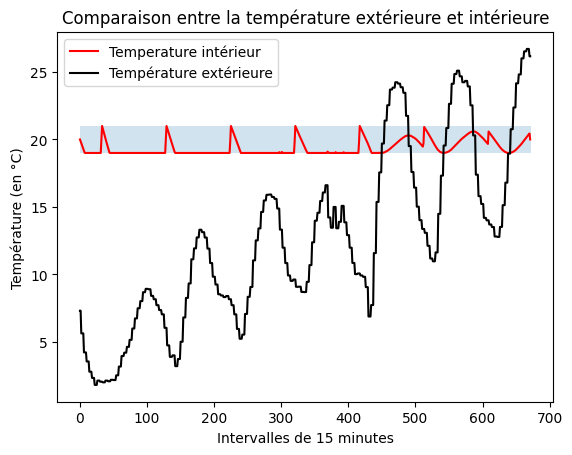

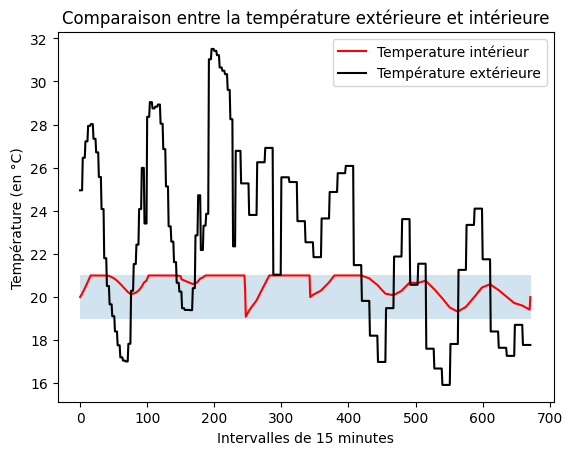

In [119]:
display_temperature(temperature_in, temperature_ext, 13050)
display_temperature(temperature_in2, temperature_ext2, 18500)

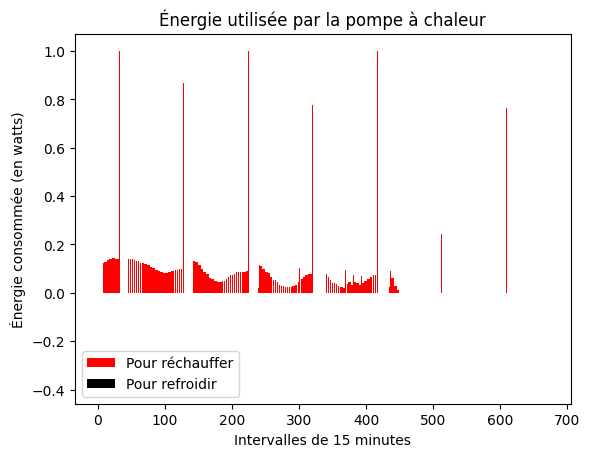

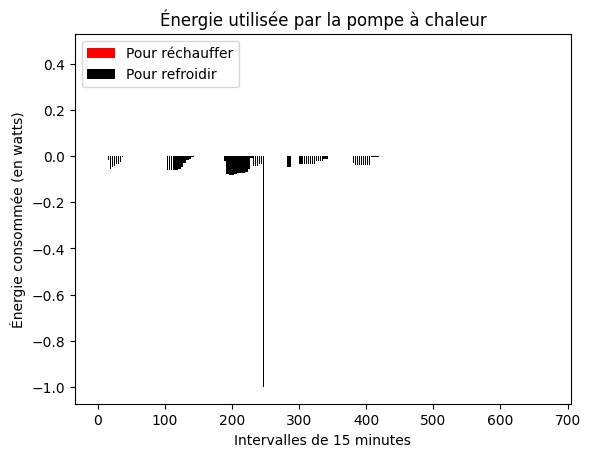

In [120]:
display_energy(énergie)
display_energy(énergie2)

# Commentaire
Les résultats observés sur nos graphes sont satisfaisants, on voit que toutes les contraintes du problème sont respectées. (précision: Une énergie négative dans le graphe ne représente pas un gain d’énergie mais bien l’énergie dépensée en mode reverse). Nous avons choisi d’observer cette deuxième semaine car elle est très chaude et permet alors d’observer que la contrainte $x_i \ge -1$ est respectée.

# Tâche 2 

## Variables de décision
Soit $I_i$ l'inconfort à l'intervalle $i$
Soit $c_i$ le coût à l'intervalle $i$
## Objectif
Minimiser l'inconfort total
$\sum_{i = 0}^{n} I_i$  sachant que l'inconfort à l'intervalle $i$ peut être définis comme ceci :
$
\begin{cases}
I_i = I_i + 3 & T_i < T\_min \\
I_i = I_i + 1 & T_i > T\_max \\
0 & sinon\\
\end{cases}
$
\
\
\
On peut également la noter d'une manière moin conditionelle. En effet, on aimerait considérer uniquement $T_i \ge T\_max$, et rien dans le cas contraire. Grâce à la fonction max on peut transformer ce système en simple équation du style.\
$
I_i = 3* max(T\_min - T_i, 0) + 1 * max(T_i - T\_max, 0) 
$

## Contraintes
$\sum_{i = 0}^{n} c_i \leq$ MAX\_BUDGET

In [121]:
def task_2(MAX_BUDGET, start_idx, NO_TIME=False):
    MIN_PENALITY = 3
    MAX_PENALITY = 1
    days_offset = 96
    end_idx = start_idx + days_offset*7
    
    depart = time.time()
    
    Tin = cp.Variable(end_idx - start_idx) # température
    x = cp.Variable(end_idx - start_idx) # énergie
    
    T0 = 20
    
    contraintes = [Tin[0] == T0]
    cout_elec = [0.18  if is_night(start_idx) else 0.26]
    
    for i in range(1, end_idx - start_idx):
        cout_elec.append(0.18) if is_night(i + start_idx) else cout_elec.append(0.26)
        
        T1 = -(1 - ETA) * (Tin[i-1] - temperatures_exterieurs[i+ start_idx]) + Tin[i-1]
        
        degre_a_compenser = degree_to_get(20, temperatures_exterieurs[i+ start_idx], x[i])
        
        contraintes.append(T1 + degre_a_compenser == Tin[i])
        
        contraintes.append(x[i] <= 1)
        contraintes.append(x[i] >= -1)
    
    contraintes.append(cp.sum(cp.multiply(cout_elec, cp.abs(x))) <= MAX_BUDGET)
    
    inconfort_func = lambda T : MIN_PENALITY * cp.maximum(MIN_TEMP - T, 0) + MAX_PENALITY * cp.maximum(T - MAX_TEMP , 0)
    
    minimise_function = cp.sum(list(map(inconfort_func, Tin)))
    
    solution = cp.Problem(cp.Minimize(minimise_function), contraintes)
    solution.solve()
    
    fin = time.time() - depart
    
    print(f"L'inconfort minimal avec un budget de {MAX_BUDGET} $ est de {solution.value}")
    
    if(not NO_TIME):
        print(f"Temps de calcul : {fin} s")    
    
    return (solution.value, Tin, x.value, fin)

In [122]:
#On prend 90% du min_cost de la tâche 1
max_budget = min_cost - 10*min_cost/100
max_budget_2 = min_cost2 - 10*min_cost2/100

min_inconfort, temperature_in, énergie, _ = task_2(max_budget, 13050)
print()
min_inconfort2, temperature_in2, énergie2, _ = task_2(max_budget_2, 18500)

L'inconfort minimal avec un budget de 7.293567425087629 $ est de 234.85986220594458
Temps de calcul : 3.1963951587677 s

L'inconfort minimal avec un budget de 2.173207196671468 $ est de 5.652680192084553
Temps de calcul : 3.082221031188965 s


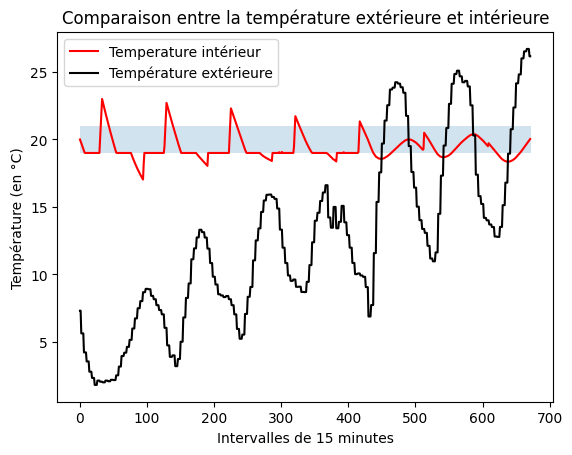

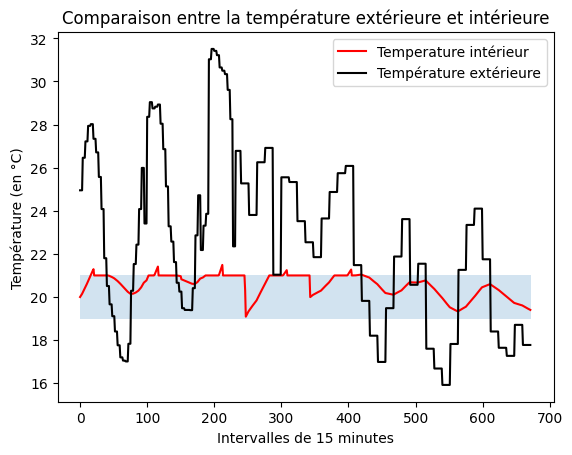

In [123]:
display_temperature(temperature_in, temperature_ext, 13050)
display_temperature(temperature_in2, temperature_ext, 18500)

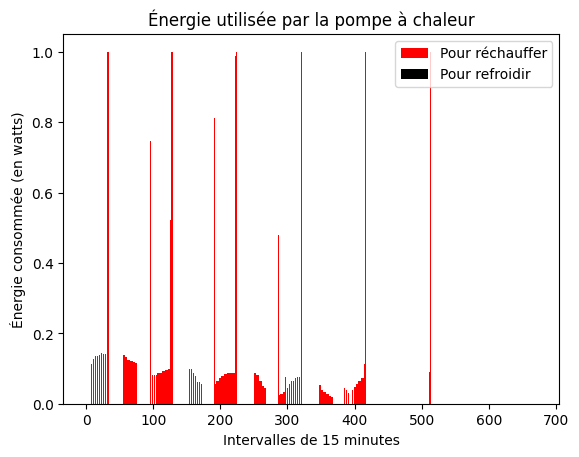

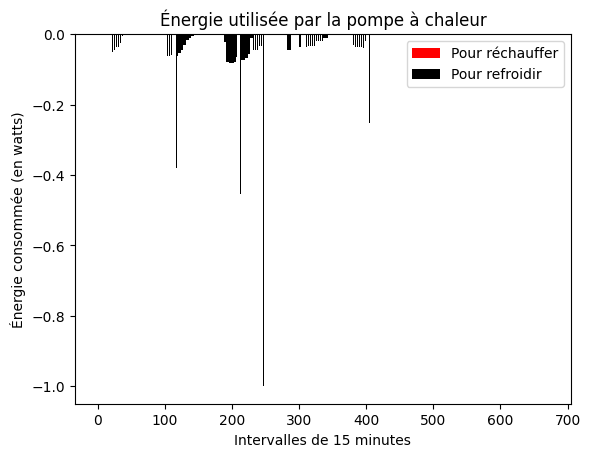

In [124]:
display_energy(énergie)
display_energy(énergie2)

# Commentaire
Nous avons fixé le budget à 90% du coût minimal trouvé à la tâche 1. On remarque sur le graphe que la température intérieure garde la même “forme générale” en prenant parfois des valeurs plus extrêmes vu qu’on ne doit pas strictement respecter l'intervalle [19; 21]. On remarque aussi que la pompe est moins souvent utilisée à cause de la limite de budget.

# Tâche 3 

## Objectif
Proposer et générer un graphe représentant la relation entre budget et inconfort.

In [125]:
#Calcul des données nécessaires
inconfort_total_sur_8_budgets_ref = []
inconfort_total_sur_8_budgets_2 = []

budget = [0, 1, 2, 3, 4, 5, 6, 7, 8]
print(budget)

total_time_budget_1 = 0
total_time_budget_2 = 0

for i in range(9):
    min_inconfort, temperature_in, énergie, _ 
    budget_1 = task_2(budget[i], 13050, NO_TIME=True)
    budget_2 = task_2(budget[i], 18500, NO_TIME=True)
    
    total_time_budget_1 += budget_1[3]
    total_time_budget_2 += budget_2[3]
    
    inconfort_total_sur_8_budgets_ref.append(budget_1[0])
    inconfort_total_sur_8_budgets_2.append(budget_2[0])

mean_time_budget_1 = total_time_budget_1 / len(budget)
mean_time_budget_2 = total_time_budget_2 / len(budget)

print(f"Temps total pour la première plage : {total_time_budget_1}")
print(f"Temps moyens pour la première plage : {mean_time_budget_1}")

print()

print(f"Temps total pour la deuxième plage : {total_time_budget_2}")
print(f"Temps moyens pour la deuxième plage : {mean_time_budget_2}")

[0, 1, 2, 3, 4, 5, 6, 7, 8]
L'inconfort minimal avec un budget de 0 $ est de 12814.284133449037
L'inconfort minimal avec un budget de 0 $ est de 1138.8629298427172
L'inconfort minimal avec un budget de 1 $ est de 10699.342447160116
L'inconfort minimal avec un budget de 1 $ est de 454.96973530725745
L'inconfort minimal avec un budget de 2 $ est de 8636.176642542265
L'inconfort minimal avec un budget de 2 $ est de 27.178919283592492
L'inconfort minimal avec un budget de 3 $ est de 6601.982555534095
L'inconfort minimal avec un budget de 3 $ est de 0.0
L'inconfort minimal avec un budget de 4 $ est de 4589.677216654765
L'inconfort minimal avec un budget de 4 $ est de 0.0
L'inconfort minimal avec un budget de 5 $ est de 2670.5292623648074
L'inconfort minimal avec un budget de 5 $ est de 0.0
L'inconfort minimal avec un budget de 6 $ est de 1255.5167538742735
L'inconfort minimal avec un budget de 6 $ est de 0.0
L'inconfort minimal avec un budget de 7 $ est de 420.23477586894325
L'inconfort min

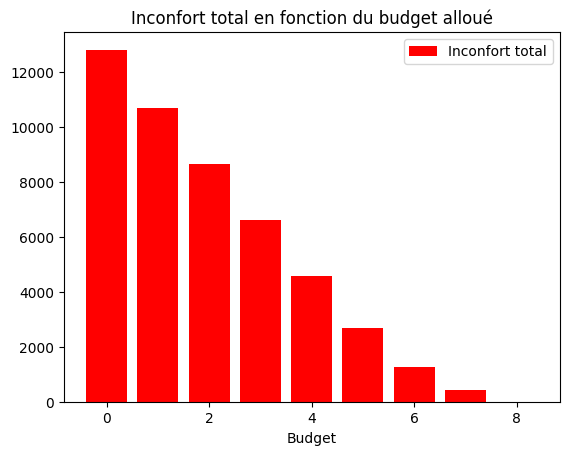

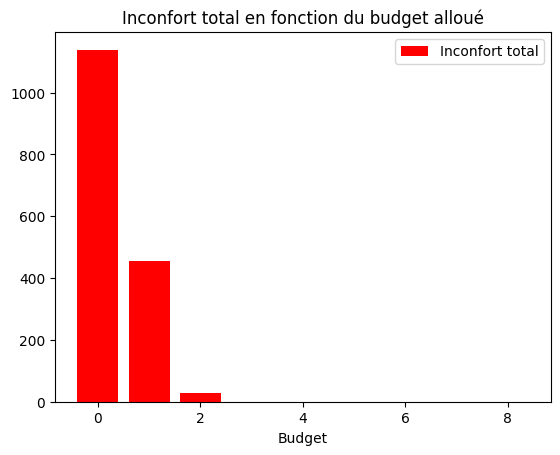

In [126]:
display_inconfort_budget(inconfort_total_sur_8_budgets_ref, budget)
display_inconfort_budget(inconfort_total_sur_8_budgets_2, budget)

# Commentaire
On remarque très nettement que l’inconfort total est inversement proportionnel au budget. Ce qui est totalement logique puisque la pompe peut être davantage utilisée pour maintenir une température optimale lorsqu’on a le budget pour lui permettre de tourner.